In [1]:
import os
#os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

import jax
import itertools
import matplotlib.cm as cm
import numpy as np
import matplotlib
# Prevent ptitprince from raising cmap errors
cm.register_cmap = lambda name, cmap : matplotlib.colormaps.register(cmap, name=name)
import ptitprince as pt

import jax.numpy as jnp
import pypomp as pp
import ipywidgets as widgets
import pandas as pd
import copy

from jax import jit, grad
from functools import partial

from tqdm import tqdm


import matplotlib.pyplot as plt
plt.style.use('matplotlibrc')
np.set_printoptions(suppress=True)

In [2]:
from pypomp.train import _jgrad_mop
d = pp.dacca(gamma=False)
theta = d.theta
theta_orig = np.hstack(list(d.par_trans.to_est(theta[0]).values()))
grads = {'0.0' : [], '1.0' : [], '0.97' : []}
alphas = [0.,1.,0.97]
for i in tqdm(range(100)):
  for alpha in alphas:
    d.train(J=10000, M=1, 
                          theta=theta,
                        optimizer='SGD', eta=1, 
                          ls=False, scale=False, 
                          alpha=alpha, key=jax.random.PRNGKey(i))
    theta_new = np.hstack(list(d.par_trans.to_est(d.theta[0]).values()))
    grads[str(alpha)].append(theta_new - theta_orig)

  0%|          | 0/100 [00:07<?, ?it/s]


KeyboardInterrupt: 

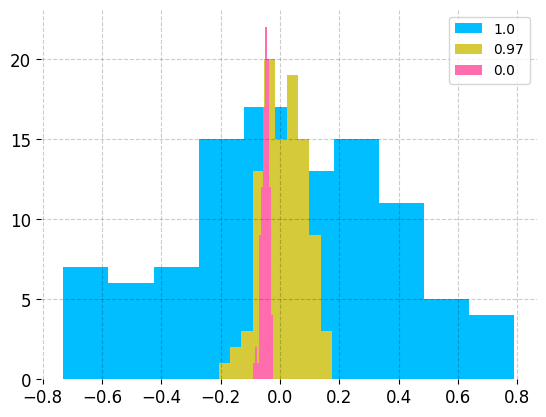

In [88]:
for alpha in [1.0, 0.97, 0.0]:
    plt.hist(np.array(grads[str(alpha)])[:,0], alpha=1, label=alpha)
plt.legend()

In [2]:
params_box = {'gamma': [10.,  40.],
                 'epsilon': [0.20, 30.00],
                 'rho': [0.0, 0.0],
                 'm': [0.03, 0.60],
                 'c': [1.0, 1.0],
                 'beta_trend': [-1.*0.01, -0.*0.01],
                 'bs1': [-4., 4.],
                 'bs2': [0., 8.],
                 'bs3': [-4., 4.],
                 'bs4': [0., 8.],
                 'bs5': [0., 8.],
                 'bs6': [0., 8.],
                 'sigma': [1., 5.],
                 'tau': [0.1, 0.5],
                 'omega': [np.exp(-4.5), np.exp(-4.5)],
                 'omegas1': [-10., -0.],
                 'omegas2': [-10., -0.],
                 'omegas3': [-10., -0.],
                 'omegas4': [-10., -0.],
                 'omegas5': [-10., -0.],
                 'omegas6': [-10., -0.]}

In [ ]:
MAIN_SEED = 631409
key = jax.random.key(MAIN_SEED)
np.random.seed(MAIN_SEED)

RW_SD = pp.RWSigma(
    sigmas={
        "gamma": 0.02,
        "m": 0.02,
        "rho": 0.0,
        "epsilon": 0.02,
        "omega": 0.02,
        "c": 0.02,
        "beta_trend": 0.02,
        "sigma": 0.02,
        "tau": 0.02,
        "bs1": 0.02,
        "bs2": 0.02,
        "bs3": 0.02,
        "bs4": 0.02,
        "bs5": 0.02,
        "bs6": 0.02,
        "omegas1": 0.02,
        "omegas2": 0.02,
        "omegas3": 0.02,
        "omegas4": 0.02,
        "omegas5": 0.02,
        "omegas6": 0.02,
    },
    init_names=[],
)

COOLING_RATE = 0.5
NP_FITR = NP_EVAL = 10000

N_TRIALS = 100
NREPS_EVAL = 1
NFITR_MIF = 40
NFITR_GD = 60


# NREPS_EVAL = 1
# NFITR_MIF = 2 #40
# NFITR_GD = 2
#N_TRIALS = 2
alphas = [0.,1.,0.97]
daccas_pre = []
daccas_mif = []
daccas_alphas = {str(alpha) : [] for alpha in alphas}

starting_logliks = []
mif_logliks = []


dacca_obj = pp.dacca(gamma=False)
for trial in tqdm(range(N_TRIALS)):
    dacca_obj.results_history = []
    key, subkey = jax.random.split(key)
    theta = pp.Pomp.sample_params(params_box, 1, key=subkey)[0]
    key, subkey = jax.random.split(key)
    dacca_obj.pfilter(J=NP_EVAL, reps=NREPS_EVAL, key=subkey, theta=theta)
    print('trial ' + str(trial) + ' init :', dacca_obj.results())
    
    key, subkey = jax.random.split(key)
    dacca_obj.mif(
            theta=theta,
            rw_sd=RW_SD,
            M=NFITR_MIF,
            a=COOLING_RATE,
            J=NP_FITR,
            key=subkey
        ) #0.95
    
    #warm_start_theta = dacca_obj.theta
    trace = dacca_obj.results_history[-1]['traces']
    argmax = int(trace[0,:,0].argmax())

    warm_start_theta = pd.DataFrame(trace[0,argmax,1:].values, index=theta.keys())[0]
    warm_start_theta = [{k : float(v) for k, v in warm_start_theta.items()}]
    
    key, subkey = jax.random.split(key)
    dacca_obj.pfilter(J=NP_EVAL, reps=NREPS_EVAL)
    print('trial ' + str(trial) + ' mif 40:', dacca_obj.results())
    daccas_pre.append(dacca_obj.results())

    key, subkey = jax.random.split(key)
    dacca_obj.mif(
                theta=theta,
                rw_sd=RW_SD,
                M=NFITR_MIF+NFITR_GD,
                a=COOLING_RATE,
                J=NP_FITR,
                key=subkey
            )
    
    key, subkey = jax.random.split(key)
    dacca_obj.pfilter(J=NP_EVAL, reps=NREPS_EVAL)
    print('trial ' + str(trial) + ' mif 100:', dacca_obj.results())
    daccas_mif.append(dacca_obj.results())

    for alpha, eta in tqdm(zip(alphas, [0.1, 0.05, 0.2])):
        key, subkey = jax.random.split(key)
        dacca_obj.train(J=NP_FITR, M=NFITR_GD, 
                          theta=warm_start_theta,
                        optimizer='SGD', eta=eta, 
                          ls=False, scale=False, 
                          alpha=alpha, key=subkey)
        key, subkey = jax.random.split(key)
        dacca_obj.pfilter(J=NP_EVAL, reps=NREPS_EVAL)
        print('trial ' + str(trial) + ' alpha=', str(alpha),':', dacca_obj.results())
        daccas_alphas[str(alpha)].append(dacca_obj.results())

  0%|          | 0/100 [00:00<?, ?it/s]

trial 0 init :         logLik  se      gamma    epsilon  rho         m    c  beta_trend  \
0 -14715.84375 NaN  34.645187  10.470056  0.0  0.533827  1.0   -0.002874   

        bs1       bs2  ...      bs6     sigma       tau     omega   omegas1  \
0 -0.793052  5.290325  ...  2.56705  3.964456  0.112241  0.011109 -2.392839   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -7.877694 -1.420382 -3.457628 -0.317747 -3.187977  

[1 rows x 23 columns]
trial 0 mif 40:         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3933.774658 NaN  38.017269  0.083694  0.0  9.756901  0.084818  1.0   

   beta_trend     sigma  ...       bs3      bs4       bs5       bs6   omegas1  \
0   -0.003223  3.647373  ...  1.413181  3.85019  4.039347  4.329221 -0.530728   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -6.056757 -1.352057 -6.087426 -6.186818 -8.085534  

[1 rows x 23 columns]
trial 0 mif 100:         logLik  se     gamma         m  rho   epsilon     omega    c

trial 0 alpha= 0.0 :         logLik  se      gamma        m  rho   epsilon     omega    c  \
0 -3840.486328 NaN  27.250803  0.07566  0.0  10.04126  0.143111  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.002449  4.019321  ...  0.289815  3.626678  3.742074  4.094291   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.905566 -6.410759 -1.942027 -5.673501 -5.348486 -7.311638  

[1 rows x 23 columns]


trial 0 alpha= 1.0 :         logLik  se     gamma         m  rho   epsilon     omega    c  \
0 -3783.258057 NaN  26.99498  0.091524  0.0  9.480065  0.143111  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.001444  3.557471  ...  0.445422  3.716559  3.822296  4.302311   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.924215 -6.402561 -1.843976 -5.592426 -5.364128 -7.336766  

[1 rows x 23 columns]


3it [04:23, 87.88s/it]
  1%|          | 1/100 [05:41<9:23:08, 341.30s/it]

trial 0 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3789.753418 NaN  25.255344  0.087338  0.0  11.89146  0.143111  1.0   

   beta_trend    sigma  ...       bs3       bs4       bs5       bs6   omegas1  \
0    -0.00336  3.27147  ...  0.350854  3.673904  3.831657  4.253064 -1.881059   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -6.384939 -1.982316 -5.750804 -5.430748 -7.342991  

[1 rows x 23 columns]
trial 1 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -5315.491699 NaN  22.867544  0.280638  0.0  27.449808  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.008323  2.946764  ...  3.076502  0.229012  5.189916  1.380099   

    omegas1   omegas2   omegas3   omegas4   omegas5  omegas6  
0 -8.159295 -1.197272 -9.484786 -8.835987 -2.270836 -3.64519  

[1 rows x 23 columns]
trial 1 mif 40:         logLik  se     gamma         m  rho    epsilon     omeg

trial 1 alpha= 0.0 :        logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3842.47583 NaN  13.984742  0.081389  0.0  26.175001  0.000763  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.006799  2.711241  ... -1.425469  3.295342  3.303583  4.150607   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -4.392528  3.628803 -9.332333 -3.451649 -8.000305 -2.597827  

[1 rows x 23 columns]


trial 1 alpha= 1.0 :        logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3833.89209 NaN  12.678437  0.074552  0.0  26.915138  0.000763  1.0   

   beta_trend     sigma  ...       bs3       bs4      bs5       bs6  omegas1  \
0   -0.006865  3.183573  ... -1.425502  3.262672  3.30033  4.153801  -4.4531   

    omegas2   omegas3   omegas4   omegas5  omegas6  
0  3.556423 -9.362369 -3.489751 -8.008519  -2.6069  

[1 rows x 23 columns]


3it [03:46, 75.56s/it]
  2%|▏         | 2/100 [10:05<8:03:21, 295.93s/it]

trial 1 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3832.128174 NaN  12.625983  0.072477  0.0  25.474817  0.000763  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.006747  3.173071  ... -1.422271  3.296109  3.315796  4.068932   

    omegas1   omegas2  omegas3   omegas4   omegas5   omegas6  
0 -4.425174  3.665683 -9.29922 -3.446732 -8.045824 -2.638721  

[1 rows x 23 columns]
trial 2 init :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -5129.739746 NaN  17.373196  0.099508  0.0  24.96874  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003512  2.582504  ...  1.054761  3.081449  1.561035  6.462576   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -7.311194 -5.770906 -2.122004 -8.232218 -0.168401 -7.556738  

[1 rows x 23 columns]
trial 2 mif 40:         logLik  se      gamma         m  rho    epsilon     o

trial 2 alpha= 0.0 :         logLik  se      gamma         m  rho  epsilon     omega    c  \
0 -3828.107422 NaN  23.045483  0.065505  0.0  8.75415  0.011122  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.002604  3.772904  ... -0.659583  3.788418  3.528291  4.120525   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -7.851612 -4.860883 -2.283096 -5.795371 -5.119499 -8.051092  

[1 rows x 23 columns]


trial 2 alpha= 1.0 :        logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3785.02124 NaN  23.772875  0.077619  0.0  8.296688  0.011122  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0    -0.00631  3.306091  ... -0.503023  3.907014  3.562588  4.303992   

    omegas1   omegas2   omegas3   omegas4  omegas5   omegas6  
0 -7.853335 -4.852461 -2.223157 -5.756794  -5.1564 -8.071158  

[1 rows x 23 columns]


3it [03:46, 75.54s/it]
  3%|▎         | 3/100 [14:29<7:34:55, 281.40s/it]

trial 2 alpha= 0.97 :         logLik  se      gamma         m  rho  epsilon     omega    c  \
0 -3776.577637 NaN  25.604486  0.081036  0.0  9.82155  0.011122  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003634  3.277426  ... -0.552271  3.787631  3.638449  4.275826   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -7.847976 -4.851973 -2.268203 -5.821408 -5.212414 -8.078467  

[1 rows x 23 columns]
trial 3 init :         logLik  se      gamma         m  rho  epsilon     omega    c  \
0 -5761.811035 NaN  29.844267  0.087622  0.0  3.74114  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.005178  4.944207  ...  1.968425  2.307203  5.463696  4.067067   

    omegas1   omegas2   omegas3  omegas4   omegas5   omegas6  
0 -4.761091 -3.409951 -0.605268 -3.05132 -3.887935 -4.872867  

[1 rows x 23 columns]
trial 3 mif 40:         logLik  se      gamma         m  rho    epsilon     omega  

trial 3 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3752.729736 NaN  22.341969  0.054497  0.0  21.17617  0.048131  1.0   

   beta_trend     sigma  ...       bs3      bs4       bs5       bs6   omegas1  \
0   -0.003615  3.194189  ... -1.300882  3.73166  3.613699  4.297533 -2.558872   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.418966 -3.274157 -4.340564 -6.952264 -5.246063  

[1 rows x 23 columns]


trial 3 alpha= 1.0 :         logLik  se      gamma        m  rho   epsilon     omega    c  \
0 -3751.160156 NaN  22.831478  0.05669  0.0  21.79689  0.048131  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5      bs6   omegas1  \
0   -0.004369  3.363615  ... -1.287613  3.761291  3.617062  4.29468 -2.575101   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.399937 -3.265152 -4.325181 -6.959309 -5.274422  

[1 rows x 23 columns]


3it [03:46, 75.54s/it]
  4%|▍         | 4/100 [18:53<7:19:21, 274.60s/it]

trial 3 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3749.677002 NaN  23.005123  0.060792  0.0  22.476851  0.048131  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5      bs6   omegas1  \
0   -0.004275  3.245836  ... -1.292451  3.749291  3.625087  4.32146 -2.544474   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.420532 -3.291463 -4.365938 -6.988364 -5.264109  

[1 rows x 23 columns]
trial 4 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -5402.739746 NaN  17.957466  0.362799  0.0  26.116594  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.009084  2.071959  ...  1.979115  4.299366  1.811437  3.774222   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -9.580704 -1.002574 -9.360171 -9.862537 -3.941894 -5.851972  

[1 rows x 23 columns]
trial 4 mif 40:         logLik  se      gamma         m  rho    epsilon    

trial 4 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3854.906494 NaN  14.751282  0.046562  0.0  17.98551  0.013166  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0    -0.00435  2.686088  ...  0.807127  3.093011  3.423949  4.203065   

    omegas1   omegas2    omegas3   omegas4   omegas5   omegas6  
0 -3.822414  5.011252 -11.350972 -4.803042 -4.721011 -7.886939  

[1 rows x 23 columns]


trial 4 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3847.882812 NaN  12.149766  0.040013  0.0  18.111391  0.013166  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5      bs6   omegas1  \
0   -0.003805  3.370653  ...  0.835829  3.096795  3.401468  4.10453 -3.879605   

    omegas2    omegas3   omegas4   omegas5   omegas6  
0  4.934791 -11.363325 -4.806154 -4.725626 -7.898439  

[1 rows x 23 columns]


3it [03:46, 75.54s/it]
  5%|▌         | 5/100 [23:17<7:08:47, 270.81s/it]

trial 4 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3844.709717 NaN  13.447847  0.044567  0.0  18.193336  0.013166  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.004525  3.251842  ...  0.802546  3.104657  3.403969  4.107352   

    omegas1   omegas2    omegas3   omegas4   omegas5  omegas6  
0 -3.931039  4.910788 -11.332366 -4.785935 -4.750031 -7.90238  

[1 rows x 23 columns]
trial 5 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -6098.172852 NaN  19.540045  0.110105  0.0  25.898726  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.009034  3.549231  ...  2.776061  5.046771  4.036434  5.286874   

    omegas1   omegas2   omegas3  omegas4   omegas5   omegas6  
0 -4.950332 -1.900623 -9.473301 -1.71894 -6.546921 -3.764071  

[1 rows x 23 columns]
trial 5 mif 40:         logLik  se      gamma         m  rho   epsilon     

trial 5 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3764.830322 NaN  23.690002  0.063308  0.0  11.747425  0.006013  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.004559  3.388604  ... -0.451509  3.833097  3.569029  4.410842   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.924548 -1.697074 -3.341978 -4.036922 -7.580611 -4.735302  

[1 rows x 23 columns]


trial 5 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3768.612061 NaN  23.098272  0.062522  0.0  10.715864  0.006013  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0      -0.007  3.557588  ... -0.378622  3.780946  3.552769  4.471168   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.928818 -1.666302 -3.279176 -3.997627 -7.587723 -4.745593  

[1 rows x 23 columns]


3it [03:46, 75.54s/it]
  6%|▌         | 6/100 [27:42<7:00:44, 268.55s/it]

trial 5 alpha= 0.97 :        logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3755.86377 NaN  24.166309  0.068874  0.0  14.285027  0.006013  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  omegas1  \
0    -0.00544  3.325586  ... -0.482337  3.744591  3.676767  4.413384 -1.96862   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.712644 -3.388378 -4.139468 -7.613246 -4.756067  

[1 rows x 23 columns]
trial 6 init :         logLik  se      gamma        m  rho    epsilon     omega    c  \
0 -5656.422852 NaN  33.230118  0.22049  0.0  18.264915  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003324  1.469968  ...  0.591935  1.466381  6.229389  3.482002   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -8.387662 -4.734813 -2.199841 -4.440905 -6.859964 -4.686533  

[1 rows x 23 columns]
trial 6 mif 40:         logLik  se      gamma         m  rho   epsilon     omeg

trial 6 alpha= 0.0 :        logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3789.99292 NaN  18.164185  0.061667  0.0  7.202475  0.000062  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.002024  3.017851  ... -3.467916  3.703456  3.477561  4.093315   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -8.258396 -4.010477 -3.405257 -4.217103 -9.103255 -5.274309  

[1 rows x 23 columns]


trial 6 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3777.098145 NaN  17.492571  0.066466  0.0  6.317757  0.000062  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5      bs6   omegas1  \
0    -0.00147  3.101297  ... -3.391074  3.716188  3.484208  4.10216 -8.261504   

    omegas2   omegas3   omegas4  omegas5   omegas6  
0 -4.001376 -3.360529 -4.204306 -9.11857 -5.287446  

[1 rows x 23 columns]


3it [03:46, 75.54s/it]
  7%|▋         | 7/100 [32:06<6:54:00, 267.10s/it]

trial 6 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3767.568604 NaN  19.628252  0.077208  0.0  7.504526  0.000062  1.0   

   beta_trend     sigma  ...       bs3      bs4       bs5       bs6   omegas1  \
0   -0.002708  2.970095  ... -3.382285  3.81222  3.537593  4.190351 -8.253863   

    omegas2   omegas3   omegas4  omegas5   omegas6  
0 -4.001046 -3.437213 -4.246197 -9.12134 -5.284673  

[1 rows x 23 columns]
trial 7 init :         logLik  se      gamma        m  rho   epsilon     omega    c  \
0 -6759.442871 NaN  18.909704  0.13918  0.0  6.028831  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.006688  4.139403  ...  3.298613  6.487934  6.086803  4.913311   

    omegas1   omegas2   omegas3   omegas4  omegas5  omegas6  
0 -6.144532 -4.811064 -0.822483 -0.500801 -8.89086 -9.51269  

[1 rows x 23 columns]
trial 7 mif 40:         logLik  se      gamma         m  rho   epsilon     omega    c  

trial 7 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon    omega    c  \
0 -3839.334961 NaN  23.843328  0.071992  0.0  8.533677  0.19791  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.002526  3.761678  ... -0.631092  3.750987  3.581747  4.111387   

    omegas1   omegas2   omegas3   omegas4    omegas5   omegas6  
0 -3.905476 -2.057387 -3.451247 -4.305025 -11.413943 -6.306371  

[1 rows x 23 columns]


trial 7 alpha= 1.0 :         logLik  se      gamma        m  rho  epsilon    omega    c  \
0 -3764.084717 NaN  25.451956  0.08993  0.0  7.53063  0.19791  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5      bs6   omegas1  \
0   -0.003567  3.250989  ... -0.437766  3.835051  3.708033  4.29553 -3.919196   

   omegas2   omegas3   omegas4    omegas5   omegas6  
0 -2.02566 -3.364032 -4.280869 -11.425903 -6.319129  

[1 rows x 23 columns]


3it [03:46, 75.54s/it]
  8%|▊         | 8/100 [36:30<6:48:07, 266.17s/it]

trial 7 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon    omega    c  \
0 -3779.198486 NaN  27.449217  0.092439  0.0  9.475222  0.19791  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5      bs6  omegas1  \
0   -0.003393  3.205972  ... -0.536319  3.874742  3.706482  4.24139 -3.85996   

    omegas2   omegas3   omegas4    omegas5   omegas6  
0 -2.045414 -3.520646 -4.366504 -11.423677 -6.302873  

[1 rows x 23 columns]
trial 8 init :        logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -24615.9375 NaN  11.960749  0.107022  0.0  28.090115  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.004918  1.879026  ... -0.802767  7.146185  6.554006  7.794675   

    omegas1  omegas2  omegas3   omegas4   omegas5   omegas6  
0 -3.584284 -3.94638 -9.75948 -1.214472 -9.244761 -6.952705  

[1 rows x 23 columns]
trial 8 mif 40:         logLik  se      gamma         m  rho   epsilon     omega    c

trial 8 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3782.071533 NaN  16.378296  0.051919  0.0  10.231993  1.231289  1.0   

   beta_trend   sigma  ...       bs3     bs4       bs5       bs6   omegas1  \
0   -0.004184  2.7643  ... -3.270255  3.5952  3.361596  4.282127 -0.909959   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -2.218775 -7.918479 -2.446991 -7.667374 -6.926069  

[1 rows x 23 columns]


trial 8 alpha= 1.0 :        logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3776.82251 NaN  16.648998  0.052347  0.0  10.107975  1.231289  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.006825  3.306849  ... -3.283972  3.579425  3.340841  4.374624   

    omegas1   omegas2   omegas3   omegas4  omegas5  omegas6  
0 -0.902628 -2.230374 -7.945635 -2.451175 -7.66463 -6.93196  

[1 rows x 23 columns]


3it [03:46, 75.54s/it]
  9%|▉         | 9/100 [40:54<6:42:42, 265.52s/it]

trial 8 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3771.864014 NaN  17.227806  0.056451  0.0  11.565319  1.231289  1.0   

   beta_trend    sigma  ...       bs3       bs4      bs5       bs6   omegas1  \
0   -0.005702  3.10332  ... -3.270269  3.569189  3.38211  4.343813 -0.995127   

   omegas2   omegas3   omegas4   omegas5   omegas6  
0  -2.2559 -7.884063 -2.471406 -7.713218 -6.946807  

[1 rows x 23 columns]
trial 9 init :          logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -12691.905273 NaN  38.537724  0.414218  0.0  12.21839  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.007939  2.999188  ... -2.929709  5.684617  5.874393  3.071423   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -5.558666 -9.935813 -4.558177 -3.791138 -2.117615 -5.755436  

[1 rows x 23 columns]
trial 9 mif 40:         logLik  se      gamma         m  rho   epsilon     omeg

trial 9 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3787.589355 NaN  16.526659  0.056638  0.0  6.849853  0.015885  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  omegas1  \
0   -0.002572  2.771677  ... -7.465022  3.958247  3.155136  4.447471 -0.64662   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -7.490108 -4.037051 -3.740387 -5.647933 -7.859939  

[1 rows x 23 columns]


trial 9 alpha= 1.0 :         logLik  se     gamma         m  rho   epsilon     omega    c  \
0 -3783.610107 NaN  15.48735  0.056079  0.0  6.006498  0.015885  1.0   

   beta_trend     sigma  ...      bs3       bs4       bs5       bs6   omegas1  \
0   -0.002871  3.336654  ... -7.47222  3.955278  3.113796  4.428028 -0.654889   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -7.491019 -4.015108 -3.673651 -5.630907 -7.873162  

[1 rows x 23 columns]


3it [03:46, 75.54s/it]
 10%|█         | 10/100 [45:18<6:37:39, 265.11s/it]

trial 9 alpha= 0.97 :       logLik  se      gamma         m  rho  epsilon     omega    c  \
0 -3774.0354 NaN  16.681396  0.061616  0.0  7.28475  0.015885  1.0   

   beta_trend     sigma  ...      bs3      bs4       bs5       bs6   omegas1  \
0   -0.004018  3.137556  ... -7.44889  3.88344  3.175014  4.465125 -0.618145   

    omegas2   omegas3   omegas4  omegas5  omegas6  
0 -7.472304 -4.048201 -3.877543 -5.75319 -7.86998  

[1 rows x 23 columns]
trial 10 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -6614.845703 NaN  12.925014  0.196637  0.0  19.732832  0.011109  1.0   

   beta_trend    sigma  ...       bs3       bs4       bs5      bs6  omegas1  \
0   -0.003358  2.88493  ...  2.348835  4.655869  6.225931  2.88085 -3.98538   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -7.868078 -6.168388 -0.237432 -9.080296 -0.109503  

[1 rows x 23 columns]
trial 10 mif 40:         logLik  se     gamma         m  rho  epsilon     omega    c  \
0 -383

trial 10 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3789.669434 NaN  19.643196  0.060521  0.0  8.327212  0.001107  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5     bs6   omegas1  \
0   -0.003073  3.143731  ... -3.283192  3.703383  3.632452  3.9382 -1.855081   

     omegas2   omegas3   omegas4    omegas5   omegas6  
0 -10.882737 -5.900705 -1.474968 -13.554225 -2.007583  

[1 rows x 23 columns]


trial 10 alpha= 1.0 :       logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3791.5625 NaN  17.974812  0.063064  0.0  7.185671  0.001107  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.005184  3.312865  ... -3.294492  3.820854  3.617775  4.078667   

    omegas1    omegas2   omegas3   omegas4    omegas5   omegas6  
0 -1.859457 -10.884521 -5.843892 -1.360372 -13.532907 -1.996493  

[1 rows x 23 columns]


3it [03:46, 75.54s/it]
 11%|█         | 11/100 [49:42<6:32:47, 264.80s/it]

trial 10 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3771.035889 NaN  18.549625  0.064482  0.0  9.186786  0.001107  1.0   

   beta_trend     sigma  ...      bs3       bs4       bs5       bs6   omegas1  \
0   -0.004296  2.971677  ... -3.27353  3.662852  3.599762  4.091457 -1.915676   

     omegas2   omegas3   omegas4   omegas5   omegas6  
0 -10.881974 -5.908448 -1.554282 -13.58226 -2.073372  

[1 rows x 23 columns]
trial 11 init :          logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -10928.392578 NaN  33.531761  0.511887  0.0  23.446983  0.011109  1.0   

   beta_trend     sigma  ...     bs3       bs4       bs5       bs6   omegas1  \
0   -0.007808  2.530571  ...  3.6129  3.550982  0.499993  4.227391 -9.475808   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -9.328507 -2.114467 -6.583165 -8.483284 -5.447757  

[1 rows x 23 columns]
trial 11 mif 40:        logLik  se      gamma         m  rho  epsilon     o

trial 11 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon    omega    c  \
0 -3809.508301 NaN  22.525761  0.065419  0.0  7.975349  0.00116  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003095  3.343097  ... -1.111245  3.594552  3.675788  3.990038   

    omegas1  omegas2   omegas3   omegas4   omegas5   omegas6  
0 -8.509184  -7.8728 -2.420031 -4.442735 -8.669733 -1.158495  

[1 rows x 23 columns]


trial 11 alpha= 1.0 :         logLik  se      gamma        m  rho   epsilon    omega    c  \
0 -3788.684082 NaN  21.234179  0.06757  0.0  7.384997  0.00116  1.0   

   beta_trend     sigma  ...       bs3     bs4       bs5       bs6   omegas1  \
0   -0.006005  3.138906  ... -1.041539  3.6305  3.727345  4.048805 -8.521534   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -7.867939 -2.361809 -4.392479 -8.672956 -1.187424  

[1 rows x 23 columns]


3it [03:46, 75.54s/it]
 12%|█▏        | 12/100 [54:06<6:28:05, 264.61s/it]

trial 11 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon    omega    c  \
0 -3780.031982 NaN  23.141766  0.072383  0.0  9.217918  0.00116  1.0   

   beta_trend     sigma  ...       bs3       bs4      bs5       bs6   omegas1  \
0   -0.004218  3.139297  ... -1.084216  3.626862  3.72677  4.074341 -8.524687   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -7.869901 -2.481896 -4.536538 -8.742611 -1.262906  

[1 rows x 23 columns]
trial 12 init :          logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -17382.257812 NaN  35.419472  0.404025  0.0  21.574753  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.000568  1.697969  ... -1.551538  5.554279  1.685886  3.628942   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -7.861903 -7.560958 -7.813996 -3.554883 -3.494748 -6.657518  

[1 rows x 23 columns]
trial 12 mif 40:         logLik  se      gamma         m  rho   epsilon    

trial 12 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3815.111572 NaN  16.177961  0.058549  0.0  5.710376  0.072443  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.001414  2.535051  ... -5.170009  3.366007  3.425864  4.148792   

     omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -11.907563 -9.250036 -7.055572 -2.258141 -7.238959 -5.417614  

[1 rows x 23 columns]


trial 12 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3800.530518 NaN  15.535109  0.061337  0.0  4.997375  0.072443  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.002165  3.328181  ... -5.173705  3.369772  3.421363  4.181447   

     omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -11.909163 -9.250687 -7.053283 -2.214064 -7.230488 -5.432474  

[1 rows x 23 columns]


3it [03:46, 75.54s/it]
 13%|█▎        | 13/100 [58:30<6:23:27, 264.46s/it]

trial 12 alpha= 0.97 :         logLik  se     gamma         m  rho   epsilon     omega    c  \
0 -3792.430176 NaN  16.48056  0.064845  0.0  5.831397  0.072443  1.0   

   beta_trend     sigma  ...       bs3      bs4       bs5       bs6  \
0   -0.002761  3.111671  ... -5.177358  3.32718  3.462771  4.172747   

     omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -11.908422 -9.247601 -7.044208 -2.397386 -7.353822 -5.439773  

[1 rows x 23 columns]
trial 13 init :        logLik  se     gamma         m  rho   epsilon     omega    c  \
0 -7795.65332 NaN  13.01343  0.045494  0.0  2.424397  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.002408  2.816846  ...  2.205572  2.139312  6.728065  6.857743   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -8.252469 -8.347448 -7.151928 -9.199472 -9.176399 -8.738649  

[1 rows x 23 columns]
trial 13 mif 40:         logLik  se      gamma         m  rho  epsilon     omega 

trial 13 alpha= 0.0 :          logLik  se  gamma   m  rho  epsilon     omega    c  beta_trend  \
0 -24867.998047 NaN    NaN NaN  0.0      NaN  0.001365  1.0         NaN   

   sigma  ...  bs3  bs4  bs5  bs6  omegas1  omegas2  omegas3  omegas4  \
0    NaN  ...  NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN   

   omegas5  omegas6  
0      NaN      NaN  

[1 rows x 23 columns]


trial 13 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3797.296143 NaN  16.777586  0.064506  0.0  5.482287  0.001365  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5      bs6   omegas1  \
0   -0.006377  3.081602  ... -4.221798  4.507154  3.067351  4.43812 -6.912445   

   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -9.66161 -0.703504 -8.414344 -7.061513 -7.470879  

[1 rows x 23 columns]


3it [03:46, 75.52s/it]
 14%|█▍        | 14/100 [1:02:55<6:18:54, 264.35s/it]

trial 13 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3785.522461 NaN  18.443842  0.080289  0.0  6.003206  0.001365  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  omegas1  \
0   -0.003721  2.889926  ... -4.214509  4.492167  3.105361  4.417391 -6.90861   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -9.668535 -0.677394 -8.322564 -7.054273 -7.469352  

[1 rows x 23 columns]
trial 14 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -8441.619141 NaN  23.658813  0.170916  0.0  13.614395  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.008877  1.419953  ... -2.643795  5.330436  7.593654  5.755044   

    omegas1   omegas2   omegas3   omegas4  omegas5   omegas6  
0 -7.644916 -6.786134 -2.262888 -0.546369 -1.25988 -0.112755  

[1 rows x 23 columns]
trial 14 mif 40:         logLik  se      gamma         m  rho  epsilon     om

trial 14 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3783.914551 NaN  19.815586  0.073356  0.0  6.199059  0.003823  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003663  2.914522  ... -2.645288  3.888259  3.486612  4.123348   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -6.648287 -8.296375 -1.457851 -5.798047 -7.637872 -1.884254  

[1 rows x 23 columns]


trial 14 alpha= 1.0 :         logLik  se      gamma       m  rho  epsilon     omega    c  \
0 -3791.237061 NaN  18.931509  0.0716  0.0  5.50786  0.003823  1.0   

   beta_trend    sigma  ...      bs3       bs4       bs5       bs6   omegas1  \
0   -0.008376  3.35196  ... -2.59255  3.887154  3.499033  4.087656 -6.667755   

   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -8.28694 -1.404511 -5.793836 -7.650396 -1.917675  

[1 rows x 23 columns]


3it [03:46, 75.54s/it]
 15%|█▌        | 15/100 [1:07:19<6:14:23, 264.28s/it]

trial 14 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3778.569336 NaN  20.419966  0.077997  0.0  6.740269  0.003823  1.0   

   beta_trend    sigma  ...       bs3       bs4       bs5     bs6   omegas1  \
0   -0.004874  3.09976  ... -2.609767  3.918315  3.497077  4.1484 -6.664822   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -8.303869 -1.548492 -5.837419 -7.709417 -2.000816  

[1 rows x 23 columns]
trial 15 init :         logLik  se     gamma         m  rho   epsilon     omega    c  \
0 -6870.453125 NaN  13.42792  0.136466  0.0  4.347129  0.011109  1.0   

   beta_trend     sigma  ...      bs3       bs4       bs5       bs6   omegas1  \
0   -0.008366  1.631001  ... -2.14127  1.406668  0.004709  3.979891 -7.170211   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -7.222972 -1.636929 -3.421395 -0.671216 -0.693969  

[1 rows x 23 columns]
trial 15 mif 40:         logLik  se     gamma         m  rho   epsilon     omega    c

trial 15 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3779.134033 NaN  18.041595  0.051609  0.0  13.238325  0.333253  1.0   

   beta_trend    sigma  ...       bs3       bs4       bs5       bs6  omegas1  \
0   -0.003597  2.89636  ... -4.687669  4.094151  3.364261  4.288837 -4.62991   

   omegas2   omegas3  omegas4   omegas5   omegas6  
0 -7.39057 -2.124948 -4.88355 -7.126444 -3.274952  

[1 rows x 23 columns]


trial 15 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3782.699219 NaN  18.145973  0.050767  0.0  13.852063  0.333253  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.007941  3.311529  ... -4.706766  4.142436  3.308505  4.234682   

    omegas1  omegas2   omegas3   omegas4   omegas5   omegas6  
0 -4.656119 -7.39413 -2.120392 -4.874203 -7.139358 -3.323103  

[1 rows x 23 columns]


In [24]:
pd.concat({k : pd.concat(daccas_alphas[str(k)]).reset_index(drop=True) for k in alphas}, axis=0).to_csv('runs.csv')
pd.concat(daccas_mif).reset_index(drop=True).to_csv('mif.csv')
pd.concat(daccas_pre).reset_index(drop=True).to_csv('pre.csv')

In [ ]:
dacca_obj.results()

,logLik,se,gamma,m,rho,epsilon,omega,c,beta_trend,sigma,...,bs3,bs4,bs5,bs6,omegas1,omegas2,omegas3,omegas4,omegas5,omegas6
0,-24867.998047,NaN,1.299844,-3.120551,-inf,0.985573,-7.560599,inf,-23.142998,1.552134,...,-5.032645,-2.040696,1.194478,-1.7298,-0.868005,-5.157048,-2.049488,-6.195749,-2.077846,-0.539867


In [ ]:
[r['traces'] for r in dacca_obj.results_history if r['method']=='mif']